This notebook examines how to create a new fit_template for EIS data.
Here the focus will be the Fe XIII 203.83 line.

This line is a standard line for EIS density diagnostic.

### The fit template

The line fitting in eispac is typically perfomed by providing a fit_template, which contains information about the fitting parameters (e.g. initial guesses, constrains, etc.). 

eispac contains a number of fit_templates for different lines, but not all lines have already a fit template or peaks adaquate peaks. One such example is the Fe XIII 203.83 line.

The fit_templates are hdf5 files and they contain two main Groups, the 'template' and the 'parinfo'. These can be examined by looking at an existing template, like the one for Fe XIII 203.83 (2 centroids).

In [41]:
import h5py
import eispac

template_filename = 'fe_13_203_826.2c.template.h5'
tmplt_dir = '/Users/andysh.to/miniconda3/envs/spice/lib/python3.9/site-packages/eispac/data/templates'
template_filepath = tmplt_dir + '/' + template_filename
tmplt = eispac.read_template(template_filepath)


In [42]:
tmplt.parinfo

[{'fixed': 0,
  'limited': array([1, 0], dtype=int16),
  'limits': array([0., 0.]),
  'tied': array('    ', dtype='<U4'),
  'value': 16771.50583103254},
 {'fixed': 0,
  'limited': array([1, 1], dtype=int16),
  'limits': array([203.69033357, 203.77061358]),
  'tied': array('    ', dtype='<U4'),
  'value': 203.73047357515514},
 {'fixed': 0,
  'limited': array([1, 1], dtype=int16),
  'limits': array([0.01910828, 0.05095541]),
  'tied': array('p[5]', dtype='<U4'),
  'value': 0.03238021733632728},
 {'fixed': 0,
  'limited': array([1, 0], dtype=int16),
  'limits': array([0., 0.]),
  'tied': array('    ', dtype='<U4'),
  'value': 91795.45582031332},
 {'fixed': 0,
  'limited': array([1, 1], dtype=int16),
  'limits': array([203.78479496, 203.86507496]),
  'tied': array('    ', dtype='<U4'),
  'value': 203.8249349618271},
 {'fixed': 0,
  'limited': array([1, 1], dtype=int16),
  'limits': array([0.01910828, 0.05095541]),
  'tied': array('    ', dtype='<U4'),
  'value': 0.03238021733632728},
 {'fi

In [43]:
tmplt.template

{'component': 2,
 'data_e': array([ 58.812794,  56.238247,  53.129276,  52.76795 ,  67.32325 ,
         88.05749 , 150.41661 , 231.61967 , 269.382   , 300.87946 ,
        359.58167 , 487.76465 , 596.7857  , 598.1213  , 461.6099  ,
        283.0892  , 164.08636 ,  86.60257 ,  73.24496 ,  57.956764,
         54.898853,  49.842796], dtype=float32),
 'data_x': array([203.54788, 203.57016, 203.59244, 203.61472, 203.63698, 203.65926,
        203.68153, 203.70381, 203.72607, 203.74835, 203.77063, 203.79291,
        203.81517, 203.83745, 203.85973, 203.882  , 203.90427, 203.92654,
        203.94882, 203.97108, 203.99336, 204.01564], dtype=float32),
 'data_y': array([  659.9287 ,   589.0718 ,   615.1622 ,   600.01544,   896.79364,
         1887.4401 ,  5683.009  , 13541.543  , 18240.398  , 19389.834  ,
        32184.607  , 58953.332  , 87772.36   , 87633.914  , 51836.25   ,
        19304.982  ,  5440.7397 ,  1676.9862 ,   974.80444,   674.3135 ,
          548.70935,   444.36862], dtype=float32)

Based on the above I will try to create my own template for another line.
First fitting the data for an 'average' pixel, getting the fit parameters and then creating the 'template' and the 'parinfo'.

### Fitting the data 

In [44]:
import scipy.io as io
import eispac
import numpy as np 
import os 
import matplotlib.pyplot as plt


Data file,
   /Users/andysh.to/Script/Python_Script/spice/SO_EIS_data/eis_20230327_131642.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/spice/SO_EIS_data/eis_20230327_131642.head.h5
Found a wavelength 203.80 [Angstroms] in window 12
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


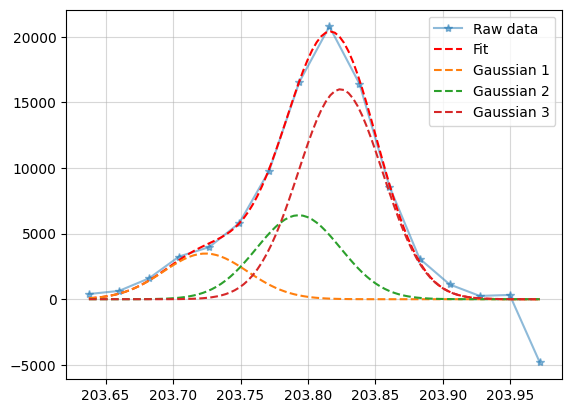

In [45]:
## Method 1

# Use the astropy library and the LevMar method
from astropy import modeling

# Load the data
data_dir = 'SO_EIS_data'
data_name = 'eis_20230327_131642.data.h5'
data_filepath = os.path.join(data_dir,data_name)
data_cube = eispac.read_cube(data_filepath,203.8) #Fe XIII

# Select a pixel
ix = 70#35#30#20
iy = 30#150#100#30

## Maunally reduce the wavelength extend for fitting,
# this is done to insure the fitting of only the line that I am
# interested in. The extend of this wavelengt window depends on the
# line profile at different positions.
wvl = data_cube.wavelength[iy,ix,:][0:-8]
rawdata = data_cube.data[iy,ix,:][0:-8]
data_err = data_cube.uncertainty.array[iy, ix, :][0:-8]

# Specify the wavelengths of the 3 Gaussians
wvl_g1 = 203.71
wvl_g3 = 203.83

# Initial guesses for 3 Gaussians
amp_g1 = max(rawdata) / 3
std_g1 = np.std(wvl) / 3
amp_g3 = max(rawdata) / 3
std_g3 = np.std(wvl) / 3

# Fitting
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D(amplitude=amp_g1, mean=wvl_g1, stddev=std_g3-0.1, fixed={'mean': True},
                                  tied={'mean': lambda m: m[2].mean - 0.1,
                                         'stddev': lambda m: m[2].stddev}) + \
        modeling.models.Gaussian1D(amplitude=0.4*amp_g3, mean=wvl_g3-0.031, stddev=std_g3,
                                   tied={'amplitude': lambda m: 0.4 * m[2].amplitude,
                                         'mean': lambda m: m[2].mean - 0.031,
                                         'stddev': lambda m: m[2].stddev}) + \
        modeling.models.Gaussian1D(amplitude=amp_g3, mean=wvl_g3, stddev=std_g3)

fitted_model = fitter(model, wvl, rawdata)

# Plotting
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(wvl, rawdata, '*-', label='Raw data', alpha=0.5)
wvl_arr = np.linspace(min(wvl), max(wvl), 100)
ax.plot(wvl_arr, fitted_model(wvl_arr), 'r--', label='Fit')
# Plot individual Gaussian components
for i in range(3):
    ax.plot(wvl_arr, fitted_model[i](wvl_arr), '--', label=f'Gaussian {i+1}')

ax.grid(alpha=0.5)
ax.legend()

### Create new template

The __template__ is a dictionairy and the __parinfo__ a list of dictionairies, from [here](https://github.com/USNavalResearchLaboratory/eispac/blob/7a480262aac6a45188f5c88865f1909424556d03/eispac/core/read_template.py#L10)

Update:
It is better to write the fit_template as an hdf5 file and then read that file with eispac.read_template.

In [69]:
## My template

model_params = fitted_model.parameters

# print(fitted_model.param_names)

background = 30. #manual selection for the time being

my_fit = np.append(model_params,background)

fit_line_list = np.array(['Fe XIII 203.71', 'Fe XIII 203.80', 'Fe XIII 203.83'],dtype='S')#!!!

# dtype 'S' for zero terminated bytes.
# This dtype is not recommended in the numpy documentation but
# here is used to reproduce exactly the format of existing templates
# https://numpy.org/doc/stable/reference/arrays.dtypes.html#arrays-dtypes-constructing

# #---Template---
# following the format of existing templates
my_FeXIII_template = {'component':np.array([3],dtype=np.int16),
                      'data_e': data_err,
                      'data_x': wvl,
                      'data_y': rawdata,
                      'fit': my_fit,
                      'fit_back': np.array([30]),
                      'fit_gauss': my_fit[0:-1],
                      'line_ids': fit_line_list,
                      'n_gauss':np.array([3],dtype=np.int16),
                      'n_poly':np.array([1],dtype=np.int16),
                      'order':np.array([1],dtype=np.int16),
                      'wmax':np.array([204.03],dtype=np.float32),
                      'wmin':np.array([203.54],dtype=np.float32)
                     }

# # ---Parinfo---
tied = np.bytes_(['','p[7]-0.1','p[8]','p[6]*0.4','p[7]-0.031','p[8]','','','',''])

my_FeXIII_parinfo = {
    'fixed': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'limited': np.array([[1, 0], [1, 1], [1, 1], [1, 0], [1, 1], [1, 1], [1, 0], [1, 1], [1, 1], [0,0]]),
    'limits': np.array([
        [0., 0.],
        [wvl[0], wvl[-1]],
        [0.01, 0.1],
        [0., 0.],
        [wvl[0], wvl[-1]],
        [0.01, 0.1],
        [0., 0.],
        [wvl[0], wvl[-1]],
        [0.01, 0.1],
        [0., 0.]
    ]),
    'tied': tied,
    'value': my_fit
}

In [70]:
import numpy as np

# Convert my_FeXIII_parinfo to a structured NumPy array## Write the parinfo and the template in an hdf5 file
ff = h5py.File("my_Fe_XIII_template.h5", "w")
g1 = ff.create_group('template')
g2 = ff.create_group('parinfo')

for k in my_FeXIII_template.keys():
    g1.create_dataset(k, data=my_FeXIII_template[k])

for k in my_FeXIII_parinfo.keys():
    g2.create_dataset(k, data=my_FeXIII_parinfo[k])

ff.close()

In [71]:
with h5py.File('my_Fe_XIII_template.h5', 'r') as f_temp:
    print(len(f_temp['parinfo/value']))

10


In [72]:
## Read that file 
my_template_filename = 'my_Fe_XIII_template.h5'
my_tmplt_dir = os.getcwd()
my_template_filepath = my_tmplt_dir + '/' + my_template_filename
print(my_template_filepath)
my_FeXIII_tmplt = eispac.read_template(my_template_filepath)


/Users/andysh.to/Script/Python_Script/spice/my_Fe_XIII_template.h5


See how the fit_template looks

In [73]:
my_FeXIII_tmplt.central_wave

203.78499603271484

In [74]:
my_FeXIII_tmplt.template

{'component': 3,
 'data_e': array([  136.99228288,   171.10612257,   268.30771552,   383.01808575,
          424.20651429,   513.33539863,   669.27715952,   871.87527416,
          979.95982137,   874.05812787,   634.52907043,   383.50667725,
          234.53574052,   117.05797314,   131.71473436, -4821.24328613]),
 'data_x': array([203.63765696, 203.65993146, 203.68220594, 203.7044804 ,
        203.72675483, 203.74902923, 203.77130361, 203.79357796,
        203.81585228, 203.83812659, 203.86040086, 203.88267511,
        203.90494934, 203.92722354, 203.94949771, 203.97177186]),
 'data_y': array([  396.33896,   631.8776 ,  1590.5554 ,  3253.4194 ,  3971.3489 ,
         5792.194  ,  9804.407  , 16553.469  , 20785.287  , 16421.836  ,
         8582.466  ,  3092.6914 ,  1126.9929 ,   252.04817,   326.12524,
        -4821.243  ], dtype=float32),
 'fit': array([3.48058981e+03, 2.03724056e+02, 3.11867431e-02, 6.40029083e+03,
        2.03793056e+02, 3.11867431e-02, 1.60007271e+04, 2.03824056e+0

In [76]:
my_FeXIII_tmplt.parinfo

[{'fixed': 0,
  'limited': array([1, 0]),
  'limits': array([0., 0.]),
  'tied': array('', dtype='<U1'),
  'value': 3480.5898075465952},
 {'fixed': 0,
  'limited': array([1, 1]),
  'limits': array([203.63765696, 203.97177186]),
  'tied': array('p[7]-0.1', dtype='<U8'),
  'value': 203.72405648309635},
 {'fixed': 0,
  'limited': array([1, 1]),
  'limits': array([0.01, 0.1 ]),
  'tied': array('p[8]', dtype='<U4'),
  'value': 0.031186743113660615},
 {'fixed': 0,
  'limited': array([1, 0]),
  'limits': array([0., 0.]),
  'tied': array('p[6]*0.4', dtype='<U8'),
  'value': 6400.290831147104},
 {'fixed': 0,
  'limited': array([1, 1]),
  'limits': array([203.63765696, 203.97177186]),
  'tied': array('p[7]-0.031', dtype='<U10'),
  'value': 203.79305648309634},
 {'fixed': 0,
  'limited': array([1, 1]),
  'limits': array([0.01, 0.1 ]),
  'tied': array('p[8]', dtype='<U4'),
  'value': 0.031186743113660615},
 {'fixed': 0,
  'limited': array([1, 0]),
  'limits': array([0., 0.]),
  'tied': array('', d

### Fit spectra with the new template

In [77]:
if __name__ == '__main__':
    # Read spectral window into an EISCube
    data_cube = eispac.read_cube(data_filepath, my_FeXIII_tmplt.central_wave,
                                  apply_radcal=True) 
    
    
    # Fit the data, then save it to disk
    save_dir = data_dir + '/fit_res'
    fit_res = eispac.fit_spectra(data_cube, my_FeXIII_tmplt, ncpu='max')
    save_filepaths = eispac.save_fit(fit_res, save_dir=save_dir)


Data file,
   /Users/andysh.to/Script/Python_Script/spice/SO_EIS_data/eis_20230327_131642.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/spice/SO_EIS_data/eis_20230327_131642.head.h5
Found a wavelength 203.78 [Angstroms] in window 12
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 83 exposures, each with 512 spectra
 + running mpfit on 12 cores (of 12)
 + working on exposure 082

Finished computing fits!
   runtime : 0:00:30.687195
   42496 spectra fit without issues
   0 spectra have < 10 good data points
   0 spectra have bad or invalid parameters
Saving EIS fit results...
   Directory: SO_EIS_data/fit_res
   Filenames: eis_20230327_131642.fe_13_203_710.3c-0.fit.h5
              eis_20230327_131642.fe_13_203_800.3c-1.fit.h5
              eis_20230327_131642.fe_13_203_830.3c-2.fit.h5


### Examine the fit result

In [78]:
# Load the fit result
fit_res_dir = 'SO_EIS_data/fit_res'
fit_res_name = 'eis_20230327_131642.fe_13_203_830.3c-2.fit.h5'
fit_res_filepath = os.path.join(fit_res_dir,fit_res_name)
fit_res = eispac.read_fit(fit_res_filepath)

Reading fit result from, 
   SO_EIS_data/fit_res/eis_20230327_131642.fe_13_203_830.3c-2.fit.h5


In [79]:
int_map = fit_res.get_map(0,'int')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
The index of the main component in a multi-gaussian fit, was not 0


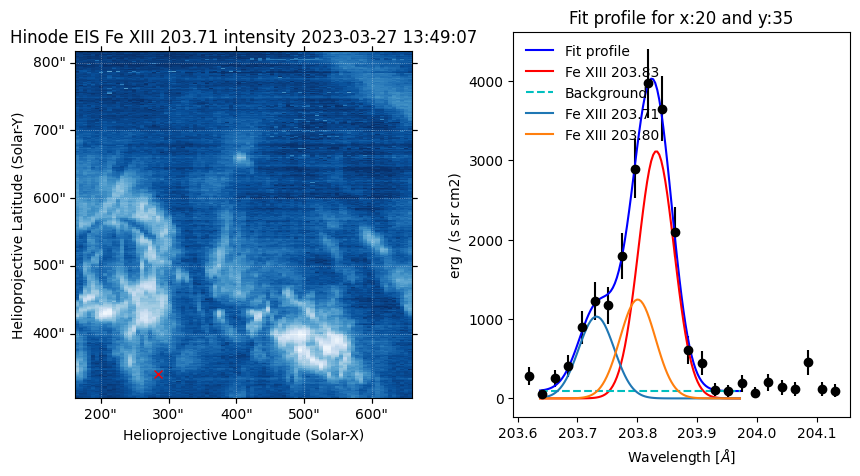

In [80]:
# Plot 
from helper_functions import plot_fit_profile as pfp 

# Select any pixel
ix = 20
iy = 35

fig = plt.figure(figsize=[10,5])
plot_grid = fig.add_gridspec(nrows=1, ncols=2, wspace=0.3)

# Intensity map
ax = fig.add_subplot(plot_grid[0,0],projection=int_map)
int_map.plot(axes=ax)
ax.plot(ix,iy,'rx')

# Fit result 
ax2 = fig.add_subplot(plot_grid[0,1])
pfp(data_cube,fit_res,iy,ix,ax2)